<a href="https://colab.research.google.com/github/pachterlab/GP_2023/blob/main/telegraph_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The telegraph process is not a subordinator

This notebook uses a modified version of the Gillespie algorithm to simulate a telegraph model of gene switching coupled to a transcription/degradation process. The resulting process dynamics are incompatible with subordinator representations.

Import relevant packages.

# Helper functions

In [1]:
import numpy as np
from numpy import matlib
import scipy.stats

import numba
import tqdm
import multiprocessing
import scipy
from scipy.fft import ifft, ifft2, ifftn, irfft, irfftn


import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import time
t1 = time.time()

## Simulation

In [2]:
@numba.njit
def update_rule(population, *args):
    '''
    Update rule that takes params and 
    updates the population matrix
    '''
    k_on, k_off, k, b1 = args
    m0, m1, m2 = population    
    flux =np.zeros(4)
    flux[0], flux[1], flux[2], flux[3] = k_on*(1-m0), k_off*m0, k*m0, b1*m1
    return flux
    
def sample_rxns(prob_arr):
    '''
    Takes prob_arr and
    returns an randomly sampled index according to 
    the probabilities specificed in prob_arr
    '''
    num = np.random.rand()
    sent = 0
    tot = 0.
    while tot < num:
        tot = tot + prob_arr[sent]
        sent = sent + 1
    return sent - 1

def step(calc_flux, population, t, *args):
    '''
    Takes flux calculating function, past event, 
    flux, population, t, args and
    returns time to reaction and the reaction that happens
    '''
    # print(args)
    flux = calc_flux( population, *args)[0]
    # print(flux)
    flux_sum = np.sum(flux)
    t = np.random.exponential(1. / flux_sum)
    rxn_prob = flux/flux_sum
    rxn = sample_rxns(rxn_prob)
    
    return rxn, t
def step_with_queued(calc_flux,population,t,queued_reactions,queued_reaction_times,export_arr,*args):
    '''
    Takes flux calculating function, past event, 
    flux, population, t, args and
    returns time to reaction and the reaction that happens
    '''
    # return step(calc_flux,population,t,*args)
    if len(queued_reactions)==0:
        return step(calc_flux,population,t,*args)
    else:
        # 
        population = np.copy(population)
        population_orig = np.copy(population)
        # queued_reactions = np.copy(queued_reactions)
        queued_reaction_times = np.copy(queued_reaction_times)

        init_flux = calc_flux( population, *args)[0]
        n_rxn = len(init_flux)
        fluxes = np.zeros((len(queued_reactions)+1,n_rxn))
        fluxes[0] = calc_flux( population, *args)[0]
        for q in range(len(queued_reactions)):
            population += export_arr[queued_reactions[q]]
            fluxes[q+1] = calc_flux( population, *args)[0]

        queued_reaction_times = np.concatenate(([t],queued_reaction_times))
        flux_sums = fluxes[:-1] * np.diff(queued_reaction_times)[:,None]
        flux_sums = np.concatenate((np.zeros(n_rxn)[None,:],flux_sums))
        flux_cumsums = np.cumsum(flux_sums,0)
        tot_flux_cumsum = flux_cumsums.sum(1)

        u = np.random.rand()
        flux = np.log(1/u)
        
        last_ind = np.where(tot_flux_cumsum<flux)[0][-1]
        dt = queued_reaction_times[last_ind]-t
        flux_orig = np.copy(flux)
        flux -= tot_flux_cumsum[last_ind]
        dtprime = flux/fluxes[last_ind].sum()
        dt += dtprime

        flux_sum = fluxes[last_ind]
        rxn_prob = flux_sum / flux_sum.sum()
        rxn = sample_rxns(rxn_prob)   
        return rxn, dt

def markovian_simulate(calc_flux, update, population_0, t_arr, tau, \
                       DELAYED_SPECIES_GENERATORS, export_arr,tau_list=None,\
                       return_full=False,*args):
    '''
    Takes params and
    returns matrix of the number of counts for 
    a species j at time t[i]
    '''
    if isinstance(tau , list) or isinstance(tau , tuple) :
        n_delays = len(tau)
    else:
        tau = [tau]
        n_delays = 1

    population_arr = np.zeros((len(t_arr), update.shape[1]))
    t = t_arr[0]
    population = population_0.copy()
    population_arr[0, :] = population
    t_list = []
    population_list = []
    rxn_list = []

    t_list.append(t)
    population_list.append(population)

    # Delay time queue
    if tau_list is None:
        tau_list = [[]]*n_delays
    tau_list_delay_inds = np.asarray(sum([[j]*len(x) for j,x in enumerate(tau_list)],[]))
    tau_list_all_delays = np.concatenate(tau_list)
    tau_list_sort = np.argsort(tau_list_all_delays).astype(int)

    tau_list_delay_inds = list(tau_list_delay_inds[tau_list_sort])
    tau_list_all_delays = list(tau_list_all_delays[tau_list_sort])
    
    while t < t_arr[-1]:
        event,dt = step_with_queued(calc_flux,population,t,\
                                    tau_list_delay_inds,tau_list_all_delays,\
                                    export_arr, *args)
        

        temp_t = t + dt
        
        # Check if an export event should slot in before t + dt
        while (len(tau_list_all_delays) != 0) and (temp_t > tau_list_all_delays[0]):
            population = population + export_arr[tau_list_delay_inds[0]]
            t = tau_list_all_delays[0]
            if t>t_arr[-1]:
                break
            t_list.append(t)
            population_list.append(population)
            rxn_list.append(-tau_list_delay_inds[0]-1)
            tau_list_all_delays.pop(0) # remove element
            tau_list_delay_inds.pop(0)

        if len(tau_list_all_delays)!=len(tau_list_delay_inds):
            raise ValueError
        
        # Perform event
        population = population + update[event, :]
        t = temp_t
        t_list.append(t)
        population_list.append(population)
        rxn_list.append(event)


        for j in range(n_delays):
            if event in DELAYED_SPECIES_GENERATORS[j]:
                tau_list_all_delays.append(t + tau[j])
                tau_list_delay_inds.append(j)
        tau_list_sort = np.argsort(tau_list_all_delays).astype(int)
        tau_list_delay_inds = list(np.asarray(tau_list_delay_inds)[tau_list_sort])
        tau_list_all_delays = list(np.asarray(tau_list_all_delays)[tau_list_sort])
    
    t_only_arr = np.asarray(t_list)
    population_list= np.asarray(population_list)
    for i in range(len(t_only_arr)):
        # print(t_only_arr)
        ind = np.searchsorted(t_arr, t_only_arr[i], side = 'right')
        # print(ind)
        population_arr[ind:] = np.array(population_list[i])
    if return_full:
        return population_arr,t_only_arr,population_list,rxn_list
    else:
        return population_arr

## Simulation setup 


In [3]:
def nondelay_wrapper(N,n,K_val,A_val,beta_val,gamma_val,initcond,number_of_cells=5000,simulation_time=5,ndel=50):

    H,A,C,S,k,Hss = sim_setup(N,n,K_val,A_val,beta_val,gamma_val)

    delayed_species = []
    DELAYED_SPECIES_GENERATORS = [[]]

    tau = []

    ####
    update_arr = S

    t_arr = np.linspace(0, simulation_time, ndel,endpoint=False)


    export_arr = np.zeros((len(delayed_species),N+n),dtype=int)


    samples = np.zeros((number_of_cells, len(t_arr), N+n))


    Hss = scipy.linalg.null_space(H.T)
    Hss /= Hss.sum()
    Hss = Hss.squeeze()

    for i in tqdm.tqdm(range(number_of_cells)):
        population_0 = np.zeros(N+n,dtype=int)
        if initcond[0][0]=='thermalized':
            init_state_prob = Hss
        elif isinstance(initcond[0][1],int):
            init_state_prob = np.zeros(N)
            jinit = initcond[0][1]
            init_state_prob[jinit] = 1
        else:
            init_state_prob = initcond[0][1]
        if N>1:
            population_0[:N] = np.random.multinomial(1,init_state_prob,1)
        else:
            population_0[:N] = 1
        initial_promoter_state = np.where(population_0[:N]==1)[0][0]

        for j,condition in enumerate(initcond[1:]):
            if isinstance(condition[0],str):
                if condition[0]=='deterministic':
                    population_0[j+N] = condition[1]
                elif condition[0]=='poisson':
                    population_0[j+N] = np.random.poisson(condition[1])
            else:
                if condition[initial_promoter_state][0]=='deterministic':
                    population_0[j+N] = condition[initial_promoter_state][1]
                elif condition[initial_promoter_state][0]=='poisson':
                    population_0[j+N] = np.random.poisson(condition[initial_promoter_state][1])
# # print('initcond')
            # if condition[0]=='deterministic':
            #     population_0[j+N] = condition[1]
            # elif condition[0]=='poisson':
            #     population_0[j+N] = np.random.poisson(condition[1])
        samples[i, :, :],event_t,event_x,_ = markovian_simulate(
            propfun_generic, update_arr, population_0, t_arr, \
            tau, DELAYED_SPECIES_GENERATORS, export_arr,[[]],\
            True,(k,K_val,A_val,beta_val,gamma_val,N))
    return t_arr,samples,H,A,C,init_state_prob

In [4]:
def sim_setup(N,n,K_val,A_val,beta_val,gamma_val):

    H = np.zeros((N,N))
    for kv in K_val:
        H[kv[0],kv[1]] = kv[2]
    H -= np.diag(H.sum(1))

    A = np.zeros((N,n))
    for av in A_val:
        A[av[0],av[1]-1] = av[2]

    B = np.zeros((n,n))
    for bv in beta_val:
        B[bv[0]-1,bv[1]-1] = bv[2]
    B -= np.diag(B.sum(1))
    for gv in gamma_val:
        B[gv[0]-1,gv[0]-1] -= gv[1]
    

    Nspec = N+n
    Nrxn = len(K_val) + len(A_val) + len(gamma_val) + len(beta_val)
    S_mark = np.zeros((Nrxn,Nspec))
    k_mark = np.zeros(Nrxn)

    i=0
    for kv in K_val:
        S_mark[i,kv[0]] = -1
        S_mark[i,kv[1]] = 1
        k_mark[i] = kv[2]
        i+=1

    for av in A_val:
        S_mark[i,av[1]+N-1] = 1
        k_mark[i] = av[2]
        i+=1
        
    for bv in beta_val:
        S_mark[i,bv[0]+N-1] = -1
        S_mark[i,bv[1]+N-1] = 1
        k_mark[i] = bv[2]
        i+=1
        
    for gv in gamma_val:
        S_mark[i,gv[0]+N-1] = -1    
        k_mark[i] = gv[1]
        i+=1

    Hss = scipy.linalg.null_space(H.T)
    Hss /= Hss.sum()
    Hss = Hss.squeeze()

    S_mark = S_mark.astype(int)

    return H,A,B,S_mark,k_mark,Hss
    # print(B)

def propfun_generic(x,*args):
    # print(args)
    k,K_val,A_val,beta_val,gamma_val,N = args[0]
    nRxn = len(k)
    nCells = x.shape[0]

    a = np.zeros((nCells,nRxn),dtype=float)
    x = x.T
    a = a.T
    #######
    j = 0 
    for i in range(len(K_val)):
        a[j] = k[j] * x[K_val[i][0]]
        j+=1
    for i in range(len(A_val)):
        a[j] = k[j] * x[A_val[i][0]]
        j+=1
    for i in range(len(beta_val)):
        a[j] = k[j] * x[beta_val[i][0]+N-1]
        j+=1
    for i in range(len(gamma_val)):
        a[j] = k[j] * x[gamma_val[i][0]+N-1]
        j+=1
    # print(a)
    # print(x)
    # raise ValueError
    return a.T

## PGF computation for generic non-delayed systems (non-analytical)


In [5]:
def get_g(mx):
    u = []
    for i in range(len(mx)):
        l = np.arange(mx[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    return g

def compute_coeff(L,V,Vinv,u,j=0):
    n_u = u.shape[1]
    a = np.asarray([(V@np.diag( Vinv @ u[:,i]))[j] for i in range(n_u)]).T
    return a

def compute_eigs(C):
    L,V = np.linalg.eig(C)
    Vinv = np.linalg.inv(V)
    return L,V,Vinv


In [6]:
def pss_wrapper(H,A,C,t,mx,n,N,initcond):
    g = np.asarray(get_g(mx)).T
    L,V,Vinv = compute_eigs(C)
    coeff = np.asarray([compute_coeff(L,V,Vinv,g.T,i) for i in range(n)])
    
    if initcond[0][0]=='thermalized':
        Hfin = scipy.linalg.null_space(H.T)
        Hfin /= Hfin.sum()
        w = Hfin.squeeze()
    elif initcond[0][0]=='deterministic':
        w = np.zeros(N)
        w[initcond[0][1]] = 1
    elif initcond[0][0]=='categorical':
        w = initcond[0][1]
    else:
        raise ValueError('Not implemented')
    w = np.asarray(w,dtype=np.complex128)

    gf_initcond_prop = np.ones((g.shape[0],N),dtype=np.complex128)

    for j,condition in enumerate(initcond[1:]):
        if isinstance(condition[0],str): #Identical conditions for all states
            if condition[0]=='deterministic':
                initcond_gfun = lambda x: (x+1)**condition[1]
            elif condition[0]=='poisson':
                initcond_gfun = lambda x: np.exp(condition[1]*x)
            for i in range(g.shape[0]):
                gf_initcond_prop[i,:] *= initcond_gfun(ufun_generic(t,L,coeff[j,:,i]))
        elif len(condition)==N: #list of length N
            for k in range(N):
                if condition[k][0]=='deterministic':
                    initcond_gfun = lambda x: (x+1)**condition[k][1]
                elif condition[k][0]=='poisson':
                    initcond_gfun = lambda x: np.exp(condition[k][1]*x)
                for i in range(g.shape[0]):
                    gf_initcond_prop[i,k] *= initcond_gfun(ufun_generic(t,L,coeff[j,:,i]))
        else: 
            print(N)
            print(len(condition[0]))
            raise ValueError
    gf_initcond_prop *= w 
    gf = gfun_numerical(g,t,H,A,N,L,coeff,gf_initcond_prop)

    Pss = np.zeros((max(mx),N))
    for j in range(N):
        Pss[:,j] = np.real(ifft(gf[:,j]))
    return Pss.squeeze()

def gfun_numerical(g,t,H,A,N,L,coeff,gf_initcond):
    gf_ = np.zeros((g.shape[0],N),dtype=np.complex128)
    
    for i in (range(g.shape[0])):
        t0 = 0
        y0 = gf_initcond[i]
        
        Ufun = lambda x: np.asarray([ufun_generic(x,L,coef[:,i]) for coef in coeff])
        intfun = lambda t,y: intfun_multi(t,y,H,A,Ufun)
        res = scipy.integrate.solve_ivp(intfun,[t,t0],y0)
        while res.status == 'running':
            res.step()
        gf_[i] = res.y[:,-1]
    return gf_

def ufun_generic(x,L,coeff):
    Ufun = (np.exp(L*x)@coeff)
    return Ufun

def intfun_multi(t,y,H,A,Ufun):
    dy = np.dot(H.T,y) + np.dot(A,Ufun(t))*y
    return -dy

# Scenarios

Define parameters.

In [7]:
k_off = .1
k_on = .15

N = 2
K_val = [[0,1,k_on],
         [1,0,k_off]]

n = 1
A_val =[[1,1,20]]
    
gamma_val = [[1,3.14]]
beta_val = []
nCells = 1000

## 2-state, 1-species, homogeneous started at single state

In [8]:
initcond = [['deterministic',0],
            ['deterministic',0]]
t_arr,samples,H,A,C,init_state_prob = nondelay_wrapper(N,n,K_val,A_val,beta_val,gamma_val,initcond,number_of_cells=nCells,simulation_time=5,ndel=200)

100%|██████████| 1000/1000 [00:09<00:00, 103.20it/s]


### PMF computation for 2-state, 1-species system

In [9]:
from scipy.special import gammaln
def get_Pss_Huang(my_x, params): #By Dr. John J. Vastola, per Huang (2014)
    alpha_1, alpha_2, gamma, k_12, k_21 = params
    x_max = int(my_x[-1])
    
    lambda_0, lambda_1, d, gamma_0, gamma_1 = alpha_2, alpha_1, gamma, k_21, k_12
    
    
    gamma_0 /= d
    gamma_1 /= d
    lambda_0 /= d
    lambda_1 /= d

    dlamb = lambda_1-lambda_0
    Q = dlamb
    beta = 1 + gamma_1 + gamma_0
    alf = 1 + gamma_1

    Pss = np.zeros(x_max+1)
    m_ = np.arange(x_max+1)

    gauss_ = np.log(scipy.special.hyp1f1(alf + m_ - 1, beta + m_ - 1, -Q))
    log_m_terms = gammaln(alf - 1 + m_) - gammaln(alf - 1) \
        + gammaln(beta - 1) - gammaln(beta - 1 + m_) \
        + m_ * np.log(Q / lambda_0) - gammaln(m_ + 1) + gauss_
    
    log_n_terms = -lambda_0 + m_*np.log(lambda_0)
    for n_ in range(x_max+1):
        rang_ = range(n_+1)
        Pss[n_] = np.sum(np.exp(log_n_terms[n_] + log_m_terms[rang_] - gammaln(n_-m_[rang_]+1)))
    return Pss


In [10]:
# a e s t h e t i c s
fs_title = 18
fs_axis = 15

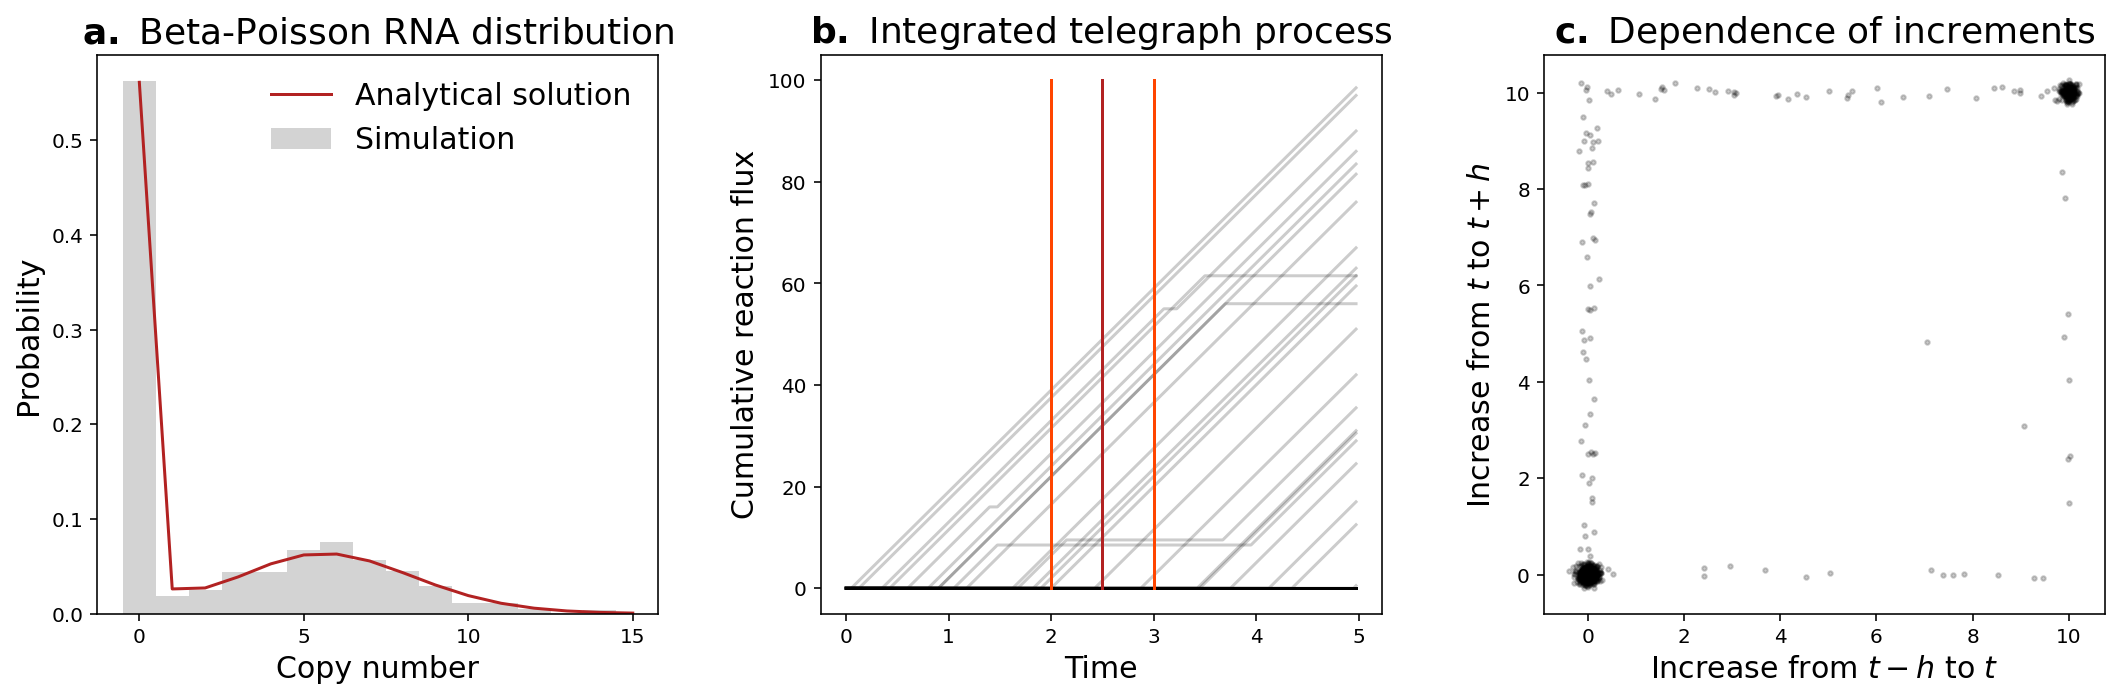

In [11]:
fig1,ax1=plt.subplots(1,3,figsize=(15,5))

X = samples[:,-1,2]
x = np.arange(X.max()+2)
bins = x-0.5

params = [  A_val[0][-1],1e-16, gamma_val[0][-1], K_val[1][-1], K_val[0][-1]]
Pss_Huang = get_Pss_Huang(x, params)
ax1[0].hist(X,bins=bins,density=True,color = 'lightgray',label='Simulation')
ax1[0].plot(x,Pss_Huang,'-',c='firebrick',label='Analytical solution')
ax1[0].set_xticks(np.arange(0,16,5))
ax1[0].set_xlabel('Copy number',fontsize=fs_axis)
ax1[0].set_ylabel('Probability',fontsize=fs_axis)
ax1[0].set_title(r'$\bf{a.}$ Beta-Poisson RNA distribution',fontsize=fs_title)
ax1[0].legend(fontsize=fs_axis,frameon=False)


dt = t_arr[1]-t_arr[0]
Y = np.cumsum(samples[:,:,1]*A_val[0][-1]*dt,1)
ax1[1].plot(t_arr,Y[:50,:].T,'k',alpha=0.2)

yval = [0,100]
t = 2.5
h = 0.5
ax1[1].plot([t]*2,yval,'-',c='firebrick')
ax1[1].plot([t+h]*2,yval,'-',c='orangered')
ax1[1].plot([t-h]*2,yval,'-',c='orangered')

ax1[1].set_xlabel('Time',fontsize=fs_axis)
ax1[1].set_ylabel('Cumulative reaction flux',fontsize=fs_axis)
ax1[1].set_title(r'$\bf{b.}$ Integrated telegraph process',fontsize=fs_title)

ti0 = np.argmin(np.abs(t_arr-t))
tim1 = np.argmin(np.abs(t_arr-(t-h)))
tip1 = np.argmin(np.abs(t_arr-(t+h)))
dYm1 = Y[:,ti0]-Y[:,tim1]
dYp1 = Y[:,tip1]-Y[:,ti0]

jit = np.random.randn(2,nCells)/10
ax1[2].scatter(dYm1+jit[0],dYp1+jit[1],5,'k',alpha=0.2)
ax1[2].set_xlabel(r'Increase from $t-h$ to $t$',fontsize=fs_axis)
ax1[2].set_ylabel(r'Increase from $t$ to $t+h$',fontsize=fs_axis)
ax1[2].set_title(r'$\bf{c.}$ Dependence of increments',fontsize=fs_title)
plt.tight_layout()
plt.savefig('fig1.png',dpi=450)